In [1]:
import pandas as pd
import numpy as np

In [2]:
colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

,ERM,KDEL,LMA,MITO,NES,NIK,NLS,NUCP,OMM,gene_id,gene_biotype,seq,struct,m6A_5UTR,m6A_CDS,m6A_3UTR
0,57.045409,35.456782,22.008215,12.355106,22.789983,24.241731,16.970436,29.348389,54.916891,ENSG00000000003,protein_coding,ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.914814,0.244517,ENSG00000000005,protein_coding,TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
2,17.449430,34.151539,29.338431,22.237585,24.682767,43.612551,38.683963,35.678476,25.348560,ENSG00000000419,protein_coding,TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
3,3.830180,2.576734,5.737850,0.761343,2.786808,2.784356,3.382682,2.463676,2.819269,ENSG00000000457,protein_coding,TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,9,5
4,13.132915,8.782925,10.061390,3.012459,8.821250,6.721117,10.827253,8.005113,6.849962,ENSG00000000460,protein_coding,AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,0.000000,0.000000,0.506809,0.075893,0.050764,0.000000,0.056586,0.000000,0.000000,ENSG00000281883,protein_coding,GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,2,1
13806,0.105452,0.087130,0.171187,0.016101,0.079057,0.669947,0.171672,0.000000,0.254546,ENSG00000282034,protein_coding,GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...,"[0.37599998712539673, 0.0, 0.07500000298023224...",0,66,4
13807,0.037093,0.444844,0.425368,0.254467,0.323794,1.803249,1.435483,0.249590,0.483645,ENSG00000282827,protein_coding,ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
13808,0.000000,0.519421,2.119115,0.360450,0.887939,0.345021,1.274465,0.741954,0.460649,ENSG00000282936,protein_coding,CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2


### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [3]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()

# DataLoader
param_dataLoader_train = {
    'padding_length': max_seq_len,
    "batch_size": 32,
    "shuffle": True
    }

param_dataLoader_valid = {
    'padding_length': max_seq_len,
    "batch_size": 32,
    "shuffle": True
    }

# KFold
param_KFold = {
    "n_splits": 5,
    "shuffle": True
    }

# Model Parameter
param_branches2 = [{'architecture': 'cdpcdpcpf',
                    'dropouts': [{'rate': .2},
                                 {'rate': .2}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 64, 'kernel_size': 5, 'activation': 'relu', 'padding': 'same'}],
                    #'dense': [{'units': 30, 'activation': 'softmax'},
                    #          {'units': 9, 'activation': 'softmax'}]
                    },
                   {'architecture': 'cdpcdpcpf',
                    'dropouts': [{'rate': .2},
                                 {'rate': .2}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 11, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 64, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'}],
                    #'dense': [{'units': 30, 'activation': 'softmax'},
                    #          {'units': 9, 'activation': 'softmax'}]
                    },
                   {'architecture': 'cdpcdpcpf',
                    'dropouts': [{'rate': .2},
                                 {'rate': .2}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 17, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 17, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 64, 'kernel_size': 17, 'activation': 'relu', 'padding': 'same'}],
                    #'dense': [{'units': 30, 'activation': 'softmax'},
                    #          {'units': 9, 'activation': 'softmax'}]
                    },
                   {'architecture': 'cdpcdpcpf',
                    'dropouts': [{'rate': .2},
                                 {'rate': .2}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 7, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 64, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'}],
                    #'dense': [{'units': 30, 'activation': 'softmax'},
                    #          {'units': 9, 'activation': 'softmax'}]
                    }]


param_branches1 = [{'architecture': 'cepr',
                   'conv': [{'filters': 64, 'kernel_size': 9, 'activation': 'relu', 'input_shape': (max_seq_len, 4)}],
                   'dense': [{'units': 9, 'activation': 'softmax'}],
                   'pooling': [{'pool_size': 27740, 'strides': 1}], 
                   'reshape': [{'target_shape': (9,)}]},
                   {'architecture': 'cepr', 
                   'conv': [{'filters': 64, 'kernel_size': 7, 'activation': 'relu', 'input_shape': (max_seq_len, 4)}],
                   'dense': [{'units': 9, 'activation': 'softmax'}],
                   'pooling': [{'pool_size': 27742, 'strides': 1}], 
                   'reshape': [{'target_shape': (9,)}]}]

param_branches3 = [{'architecture': 'cblcblpdcblcblpdcblcblpdcblcblpdaebleblee',
                    'dropouts': [{'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 7, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 7, 'activation': 'relu', 'padding': 'same'}],
                    'leaky': [{'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05}],
                    'dense': [{'units': 128, 'activation': 'softmax'},
                              {'units': 256, 'activation': 'softmax'},
                              {'units': 512, 'activation': 'softmax'},
                              {'units': 9, 'activation': 'softmax'}],
                    'batch': [{},{},{},{},{},{},{},{},{},{}]},
                   {'architecture': 'cblcblpdcblcblpdcblcblpdcblcblpdaebleblee',
                    'dropouts': [{'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 11, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 11, 'activation': 'relu', 'padding': 'same'}],
                    'leaky': [{'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05}],
                    'dense': [{'units': 128, 'activation': 'softmax'},
                              {'units': 256, 'activation': 'softmax'},
                              {'units': 512, 'activation': 'softmax'},
                              {'units': 9, 'activation': 'softmax'}],
                    'batch': [{},{},{},{},{},{},{},{},{},{}]},
                   {'architecture': 'cblcblpdcblcblpdcblcblpdcblcblpdaebleblee',
                    'dropouts': [{'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 15, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 15, 'activation': 'relu', 'padding': 'same'}],
                    'leaky': [{'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05}],
                    'dense': [{'units': 128, 'activation': 'softmax'},
                              {'units': 256, 'activation': 'softmax'},
                              {'units': 512, 'activation': 'softmax'},
                              {'units': 9, 'activation': 'softmax'}],
                    'batch': [{},{},{},{},{},{},{},{},{},{}]},
                   {'architecture': 'cblcblpdcblcblpdcblcblpdcblcblpdaebleblee',
                    'dropouts': [{'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3},
                                 {'rate': .3}],
                    'pooling': [{'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2},
                                {'pool_size': 2}],
                    'conv': [{'filters': 64, 'kernel_size': 19, 'activation': 'relu', 'input_shape': (train_data['seq'].apply(lambda x: len(x)).max(), 4)},
                             {'filters': 64, 'kernel_size': 19, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 19, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 128, 'kernel_size': 719, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 19, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 256, 'kernel_size': 19, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 19, 'activation': 'relu', 'padding': 'same'},
                             {'filters': 512, 'kernel_size': 19, 'activation': 'relu', 'padding': 'same'}],
                    'leaky': [{'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05},
                              {'alpha': 0.05}],
                    'dense': [{'units': 128, 'activation': 'softmax'},
                              {'units': 256, 'activation': 'softmax'},
                              {'units': 512, 'activation': 'softmax'},
                              {'units': 9, 'activation': 'softmax'}],
                    'batch': [{},{},{},{},{},{},{},{},{},{}]}]

params_branched = [{'epochs': 10}, {'epochs': 10}, {'epochs': 10}, {'epochs': 10}]

param_consensus = {'activation': 'softmax'}

params_train = {'epochs': 10, 'use_multiprocessing': True}

In [5]:
# training, only need for the model initialization to change in general
from models.functional_MultibranchedModel import MultiBranch

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)

model = MultiBranch(input_size=(max_seq_len, 4),
                    param_branches=param_branches2, 
                    number_branches=4, 
                    param_consensus=param_consensus,  
                    plot=True)


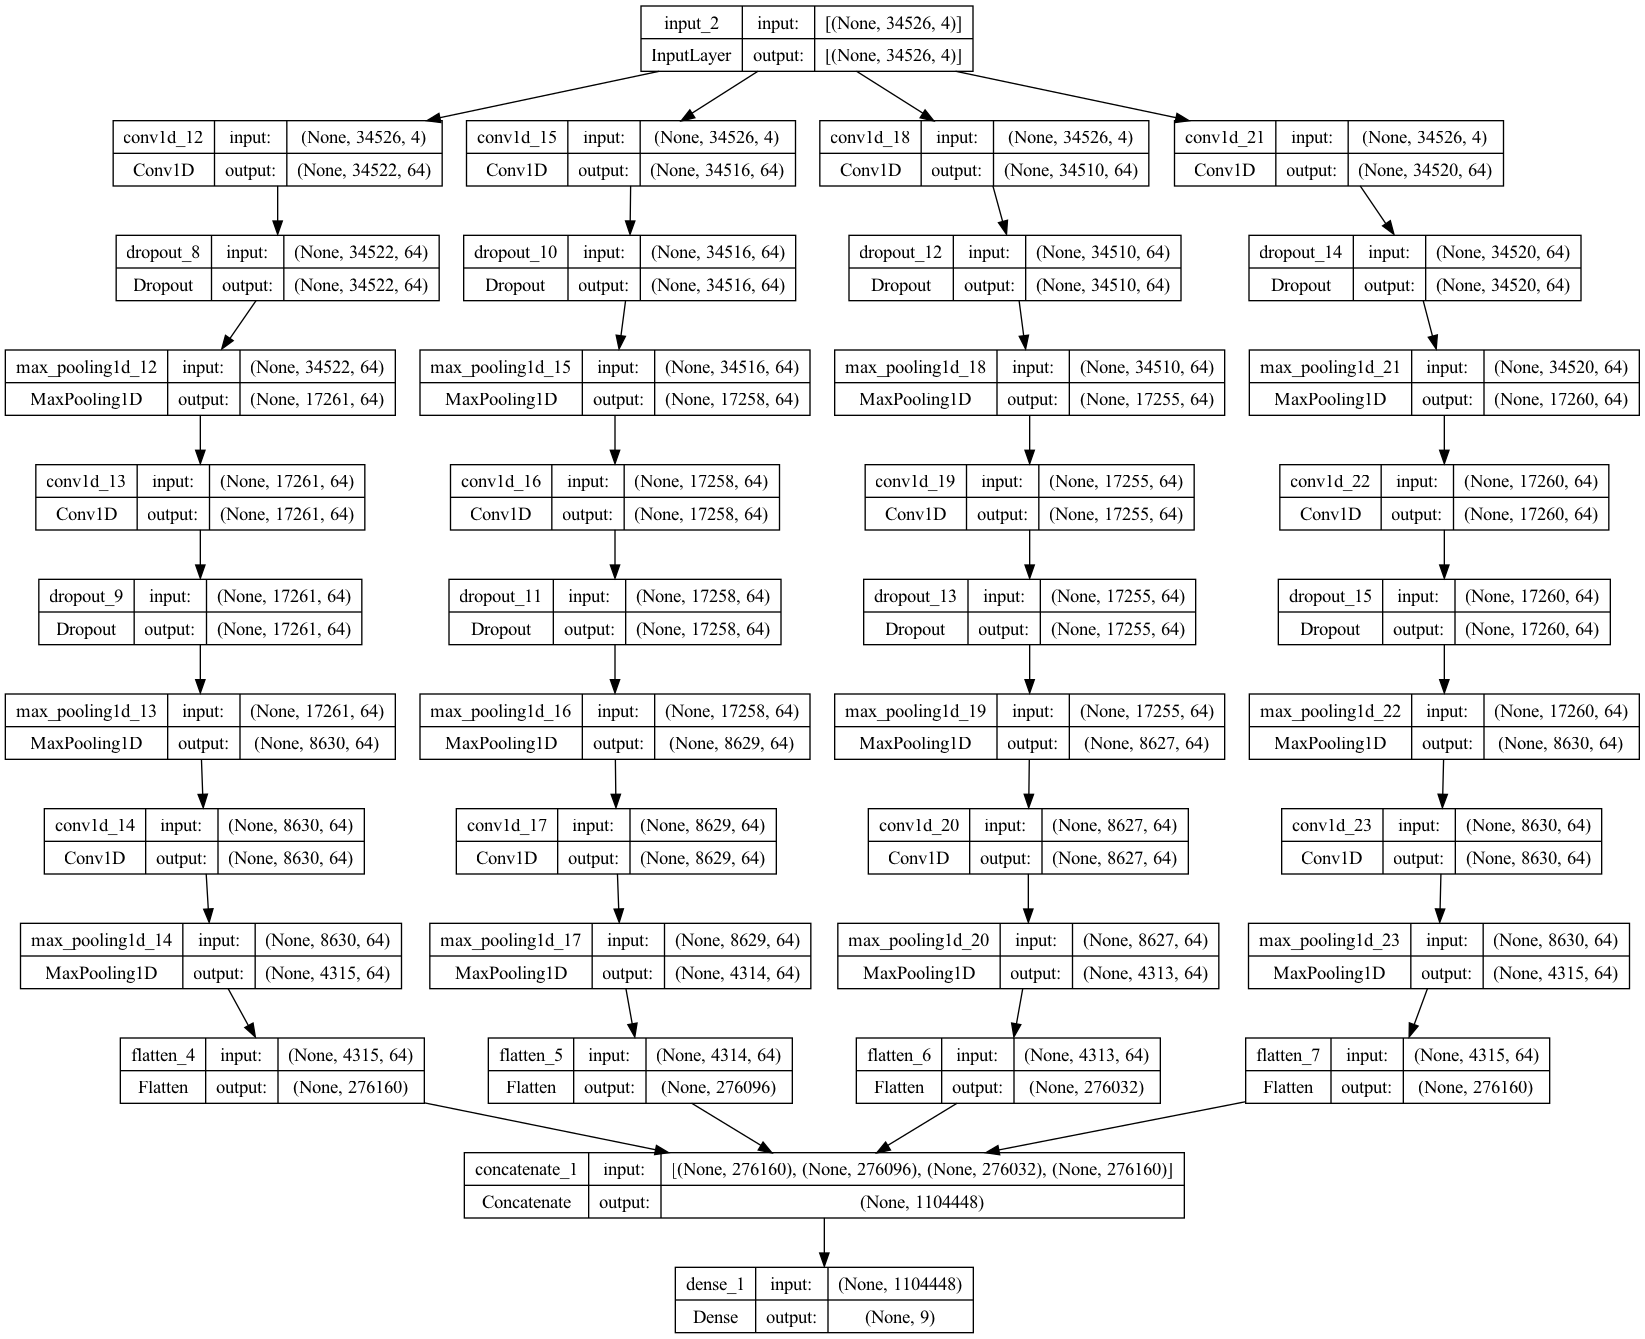

In [6]:
from keras.utils import plot_model
plot_model(model.model, show_shapes=True)

In [7]:
model.fit(train_data=train_data, params_dataLoader=param_dataLoader_train, params_train=params_train)


Epoch 1/10


2023-06-23 16:44:47.850307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 18/249 [=>............................] - ETA: 23:20 - loss: 3.3833 - accuracy: 0.1528

In [ ]:
results = model.evaluate(eval_data=valid_data, params_loader=param_dataLoader_valid)
results = dict(zip(model.final_merge_model.metrics_names, results))

VALIDATION_ACCURACY.append(results['accuracy'])
VALIDATION_LOSS.append(results['loss'])

In [5]:
results

{'loss': 2.211092948913574, 'accuracy': 0.08286403864622116}

In [6]:
test_result = model.evaluate(test_data, params_loader=param_dataLoader_valid)
result = dict(zip(model.final_merge_model.metrics_names, test_result))
TEST_ACCURACY = result['accuracy']
TEST_LOSS = result['loss']

44/44 [==============================] - 0s 577us/step - loss: 2.2103 - accuracy: 0.0992


In [ ]:
VALIDATION_ACCURACY

In [ ]:
model.predict(test_data, param_dataLoader_valid)